In [1]:
import os
import pickle
import torch
import nb_utils
from lightning_data_modules import HaarDecomposedDataset, ImageDatasets, PairedDataset, SyntheticDataset, SyntheticPairedDataset, Synthetic1DConditionalDataset, SyntheticTimeSeries, SRDataset, SRFLOWDataset, KSphereDataset, MammothDataset, LineDataset, GanDataset #needed for datamodule registration
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_modules.KSphereGroundTruthModel import KSphereGroundTruthModel
from models.ksphere_gt import KSphereGT
from models.ddpm import DDPM
from models.fcn import FCN
import pickle
import sde_lib
from dim_reduction import get_manifold_dimension
from configs.utils import read_config
from plot_utils import plot_spectrum

/store/CIA/js2164/conda_envs/score_sde/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Moving cwd to /store/CIA/js2164/repos/diffusion/score_sde_pytorch


In [5]:
with open('logs/ksphere/sample_complexity/n=250/config.pkl', 'rb')as f:
    config = pickle.load(f)
print(config.data)

ambient_dim: 100
angle_std: -1
create_dataset: false
data_samples: 250
datamodule: KSphere
dim: 100
embedding_type: random_isometry
manifold_dim: 25
n_spheres: 1
noise_std: 0.0
num_channels: 0
shape:
- 100
split:
- 0.8
- 0.1
- 0.1
use_data_mean: false



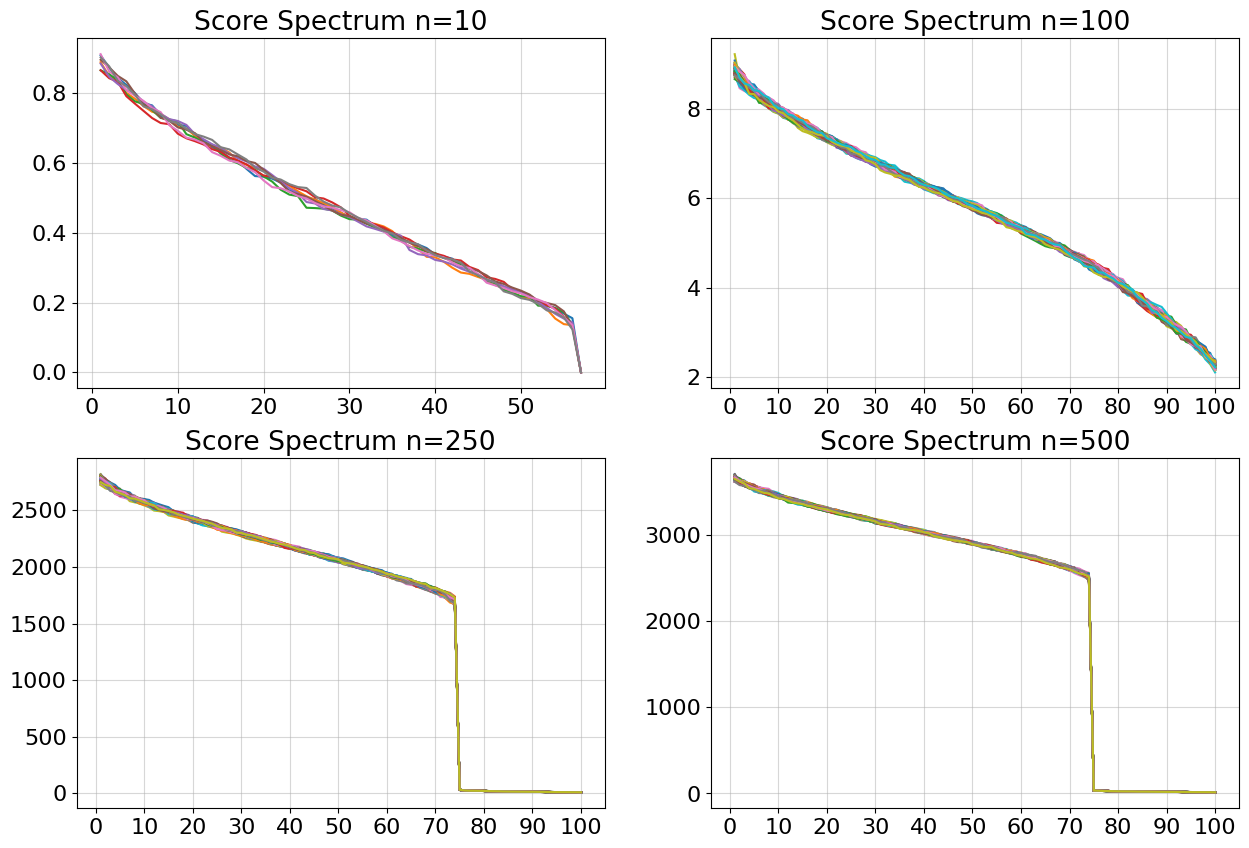

In [2]:
ns = [10, 100, 250, 500]
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes = axes.flatten()
for i, n in enumerate(ns):
    with open(f'logs/ksphere/sample_complexity/n={n}/svd/svd.pkl', 'rb') as file:
        svd = pickle.load(file)
    singular_values = svd['singular_values']
    sing_vals = singular_values[0]

    
    axes[i].grid(alpha=0.5)
    axes[i].set_title(f'Score Spectrum n={n}')
    axes[i].set_xticks(np.arange(0, len(sing_vals)+1, 10))

    for sing_vals in singular_values:
        axes[i].plot(list(range(1, len(sing_vals)+1)),sing_vals)


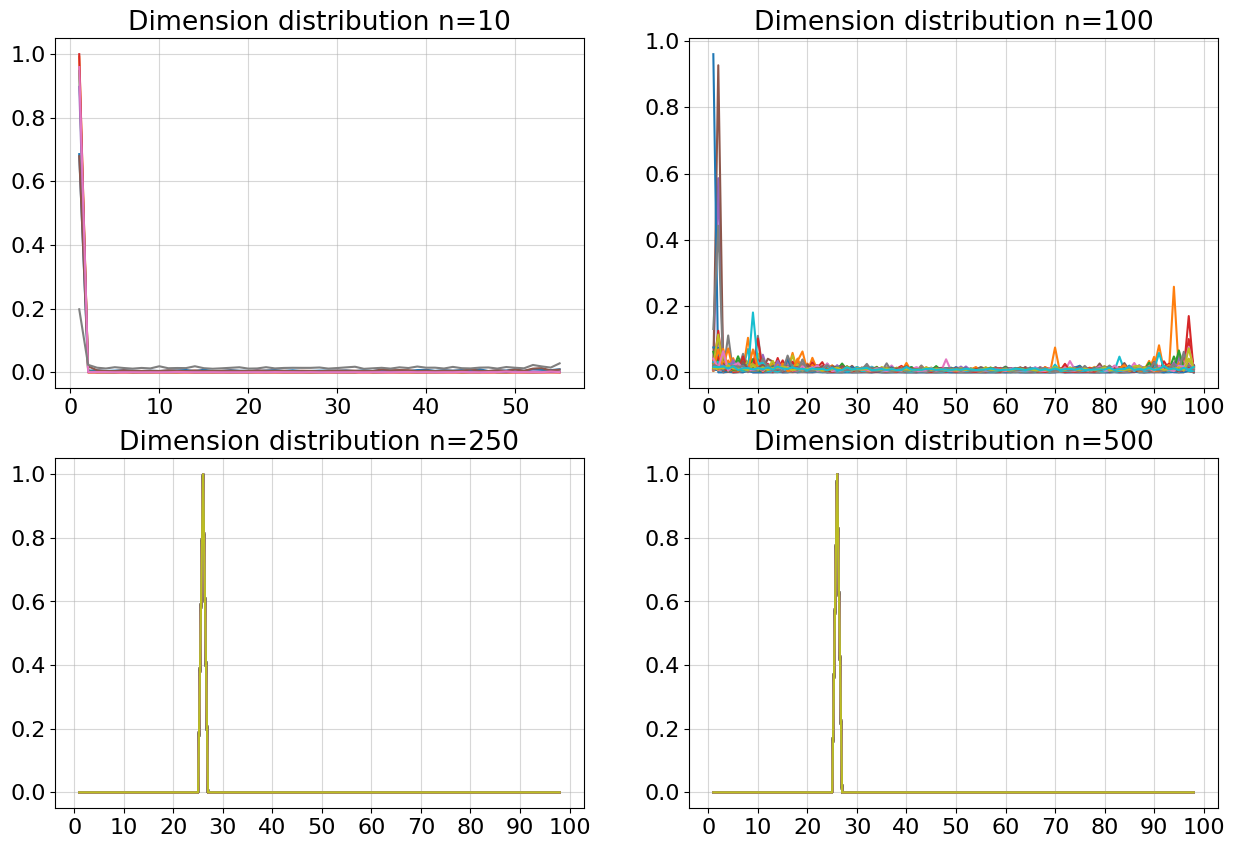

In [3]:
def softmax(x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0) # only difference

plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes = axes.flatten()
for i, n in enumerate(ns):
    with open(f'logs/ksphere/sample_complexity/n={n}/svd/svd.pkl', 'rb') as file:
        svd = pickle.load(file)
    singular_values = svd['singular_values']
    sing_vals = singular_values[0]

    
    axes[i].grid(alpha=0.5)
    axes[i].set_title(f'Dimension distribution n={n}')
    axes[i].set_xticks(np.arange(0, len(sing_vals)+1, 10))

    dims=[]
    for sing_vals in singular_values:
        s=sing_vals
        norm_factor = s[1]-s[2]
        diff = [(s[i]-s[i+1])/norm_factor for i in range(1, len(s)-1)]
        soft = softmax(diff)
        axes[i].plot(list(range(1,1+len(soft)))[::-1],soft)
        dim = len(soft)-soft.argmax()
        dims.append(dim)   



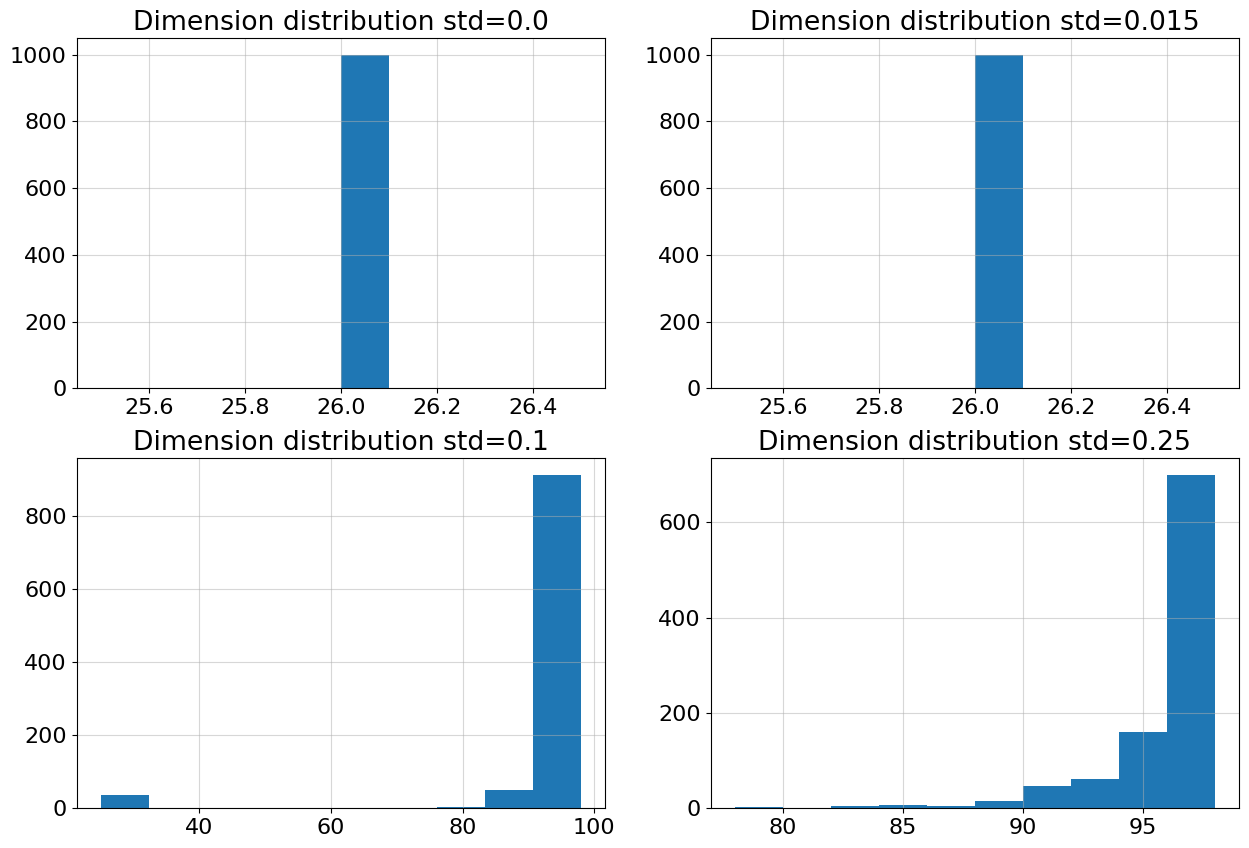

In [4]:
def softmax(x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0) # only difference

plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes = axes.flatten()
for i, std in enumerate([0.0, 0.015, 0.1, 0.25]):
    with open(f'logs/ksphere/robustness/std={std}/svd/svd.pkl', 'rb') as file:
        svd = pickle.load(file)
    singular_values = svd['singular_values']
    sing_vals = singular_values[0]

    
    axes[i].grid(alpha=0.5)
    axes[i].set_title(f'Dimension distribution std={std}')

    dims=[]
    for sing_vals in singular_values:
        s=sing_vals
        norm_factor = s[1]-s[2]
        diff = [(s[i]-s[i+1])/norm_factor for i in range(1, len(s)-1)]
        soft = softmax(diff)
        dim = len(soft)-soft.argmax()
        dims.append(dim)
    axes[i].hist(dims)   
